# GOALS (Checklist, add more if useful):

1. First, clean the data

2. Then, do EDA

3. train_test_split

4. cross_val_score

In [1]:
# All imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import patsy

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Ridge, Lasso, ElasticNet
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

In [2]:
# Reading dataset
df = pd.read_csv('../datasets/train.csv')
df_old = df
df.shape

(2051, 81)

In [3]:
# Renaming columns by replacing spaces with underscore:
df.columns = df.columns.str.replace(' ', '_')

|Column|Type|Description|
|------|----|-----------|
Id|int64|Property ID number
PID|int64|Parcel ID Number
MS_SubClass|int64|Type of Dwelling
MS_Zoning|object|General Zoning Classification
Lot_Frontage|float64|Distance along the front of the lot
Lot_Area|int64|Lot size in sqft
Street|object|Type of road access
Alley|object|Type of alley access
Lot_Shape|object
Land_Contour|object
Utilities|object
Lot_Config|object
Land_Slope|object
Neighborhood|object
Condition_1|object
Condition_2|object
Bldg_Type|object
House_Style|object
Overall_Qual|int64
Overall_Cond|int64
Year_Built|int64
Year_Remod/Add|int64
Roof_Style|object
Roof_Matl|object
Exterior_1st|object
Exterior_2nd|object
Mas_Vnr_Type|object
Mas_Vnr_Area|float64
Exter_Qual|object
Exter_Cond|object
Foundation|object
Bsmt_Qual|object
Bsmt_Cond|object
Bsmt_Exposure|object
BsmtFin_Type_1|object
BsmtFin_SF_1|float64
BsmtFin_Type_2|object
BsmtFin_SF_2|float64
Bsmt_Unf_SF|float64
Total_Bsmt_SF|float64
Heating|object
Heating_QC|object
Central_Air|object
Electrical|object
1st_Flr_SF|int64
2nd_Flr_SF|int64
Low_Qual_Fin_SF|int64
Gr_Liv_Area|int64
Bsmt_Full_Bath|float64
Bsmt_Half_Bath|float64
Full_Bath|int64
Half_Bath|int64
Bedroom_AbvGr|int64|Number of bedrooms above ground level
Kitchen_AbvGr|int64
Kitchen_Qual|object
TotRms_AbvGrd|int64|Total number of rooms above ground level excluding bathrooms
Functional|object
Fireplaces|int64
Fireplace_Qu|object
Garage_Type|object
Garage_Yr_Blt|float64
Garage_Finish|object
Garage_Cars|float64
Garage_Area|float64
Garage_Qual|object
Garage_Cond|object
Paved_Drive|object
Wood_Deck_SF|int64
Open_Porch_SF|int64
Enclosed_Porch|int64
3Ssn_Porch|int64
Screen_Porch|int64
Pool_Area|int64
Pool_QC|object
Fence|object
Misc_Feature|object
Misc_Val|int64
Mo_Sold|int64
Yr_Sold|int64
Sale_Type|object
SalePrice|int64
Garage_Exist|int64|1 if Garage Exists, 0 otherwise

In [4]:
df[['SalePrice', 'Lot_Area']].describe()

,SalePrice,Lot_Area
count,2051.000000,2051.000000
mean,181469.701609,10065.208191
std,79258.659352,6742.488909
min,12789.000000,1300.000000
25%,129825.000000,7500.000000
50%,162500.000000,9430.000000
75%,214000.000000,11513.500000
max,611657.000000,159000.000000


In [5]:
df.loc[df['Lot_Area'] > (df['Lot_Area'].mean() + 3 * df['Lot_Area'].std()), ['MS_Zoning']]
    .groupby(df['MS_Zoning']).count()

,MS_Zoning
MS_Zoning,
A (agr),1
RL,23
RM,1


In [6]:
df.groupby(df['MS_Zoning'])[['MS_Zoning']].count()

,MS_Zoning
MS_Zoning,
A (agr),2
C (all),19
FV,101
I (all),1
RH,14
RL,1598
RM,316


# Dropping Rows Based on Preliminary EDA

### Dropping Outliers: Lot Area (25 rows dropped)
As seen above, there is a large range in lot area of the houses, from a minimum of 1,300 sqft to 159,000 sqft. The drastic difference in sale price of houses in large lot areas show a high variance (shown in graph comparison below), presumably due to the difference in discounts or premiums in effect when purchasing such lots. Hence, the houses which have a noticably large size should be removed in the preliminary stage of data cleaning. 

The Empirical Rule states that in a normal distribution, 99.7% of values are within 3 Standard Deviations (StDev, 6743 sqft) of the mean (10,065 sqft). From the histogram above, we see that Sale Price roughly follows the normal distribution. As such, we omit outlier values above or below 3 StDev. There are no houses below 3 StDev, and 25 houses above 3 StDev (30293 sqft). This amounts to a deletion of 25 rows deleted, equivalent to 1.22% of total rows in the training sample. 


In [369]:
print(df['Lot_Area'].mean() + 3 * df['Lot_Area'].std())
print(df.loc[df['Lot_Area'] > (df['Lot_Area'].mean() + 3 * df['Lot_Area'].std()), 'Lot_Area']
      .count()/df.shape[0])

print(df.loc[df['Lot_Area'] > (df['Lot_Area'].mean() + 3 * df['Lot_Area'].std()), 'Lot_Area'].count())
print(df.shape[0])

30292.67491961595
0.01218917601170161
25
2051


### Dropping Outliers: Sale Price (33 rows dropped)
Similarly, sale price roughly follows a normal distribution, peaking at the \\$140,000 to $160,0000, and steadily decreasing afterwards. The housing prices which exceed the empirical rule are considered outliers due to their premiums to their lot size which results in much variance to the rest of the sample and potentially result in greater inaccuracy as compared to the norm. To eliminate the outliers, we dropped the houses whose sale price are above and below 3 StDev. This results in the elimination of 33 rows which is equivalent to XXX% of our current dataset, all of which consist of sale price above 3 StDev.

### 2.1.2. Dropping Non-Residential Zoning Type (22 Rows Dropped)

**Zone Type (Rows Dropped):** Justification for dropping rows.

**General note:** Our aim is to create a model to predict residential house prices, akin to Zillow Estimate, for residential housing. Hence, we eliminate observations whose zoning type are not residential because they are beyond the scope of our investigation and is more likely to create inaccuracies in estimating residential home prices.

**Agriculture Zone (2):** Lots for agricultural purposes based on their MS_Zoning should not be included due to the difference in type of housing, as their main purpose (agriculture) is different from our intended outcome (housing). This results in the elimination of 2 rows.

**Industrial Zone (1):** Additionally, the classification of industrial zone will not have much impact in our general prediction since there is only one data point, and the resulting prediction model is more likely to be skewed to one side due to the special classification of one row. While the effect is minimal due to only one sample size, disqualifying industrial zone in our dataset is more likely to slightly improve our model rather than worsen it. This results in the elimination of 1 row.

**Commercial Zone (19):** Commercial zones are distinctly different from ordinary housing zones. Although commercial zones can be used for residential purposes, visibility of such listings coupled with inherent valuation differences due to its nature of originally being commercially zoned skew the accuracy of prediction as compared to non-commercial residential housing. The following are two sources of the purported difference in valuation pegged onto commmercial zones: ([*source*](https://www.forbes.com/sites/joshuastein/2021/06/29/can-we-convert-underutilized-commercial-buildings-into-badly-needed-affordable-housing/)) ([*source*](https://www.washingtonpost.com/realestate/following-pandemic-converting-office-buildings-into-housing-may-become-new-normal/2021/03/31/2fec400e-8820-11eb-8a8b-5cf82c3dffe4_story.html)). In addition, we have limited data on commercial zoned properties (19, 0.9% of training dataset) which prodive minimal viability to the larger purpose of this project: predicting general residential prices. This results in the elimination of 19 rows.

<blockquote><b>
    
    Old Shape: 2048 Rows, 81 Columns
    New Shape: 2026 Rows, 81 Columns
</b></blockquote>

In [368]:
print(df['SalePrice'].mean() + 3 * df['SalePrice'].std())
print(df.loc[df['SalePrice'] > (df['SalePrice'].mean() + 3 * df['SalePrice'].std()), 'SalePrice']
      .count() / df.shape[0])

print(df.loc[df['SalePrice'] > (df['SalePrice'].mean() + 3 * df['SalePrice'].std()), 'SalePrice']
      .count())
print(df.shape[0])

419245.67966606806
0.016089712335446125
33
2051


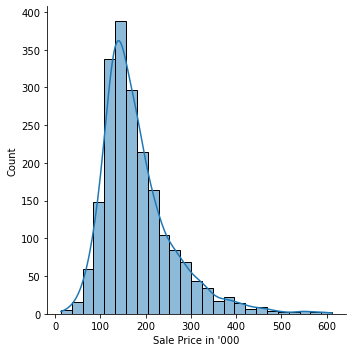

In [336]:
sns.displot(data=df['SalePrice']/1000,
            kind='hist',
            kde=True,
            bins=25,
);
plt.xlabel('Sale Price in \'000');

In [26]:
def high_density(row):
    for zone in row:
        if row['MS_Zoning'] == 'RH':
            row['RH_Zone'] = 1
        else:
            row['RH_Zone'] = 0
    return row
df2 = df.apply(high_density, axis=1)

In [47]:
def saleprice_per_lotarea(row):
    row['SP_LA'] = row['SalePrice'] / row['Lot_Area']
    return row

df2 = df2.apply(saleprice_per_lotarea, axis=1)

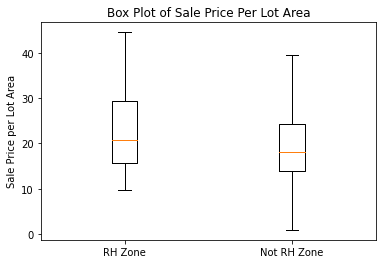

In [58]:
df2.groupby(df2['RH_Zone'])['RH_Zone'].count()
plt.boxplot([df2.loc[df2['RH_Zone'] == 1, "SP_LA"],
             df2.loc[df2['RH_Zone'] == 0, "SP_LA"]],
            showfliers=False
)
plt.title('Box Plot of Sale Price Per Lot Area')
plt.ylabel('Sale Price per Lot Area')
plt.xticks(ticks=[1, 2],
           labels=["RH Zone", "Not RH Zone"]
);

In [59]:
def commercial(row):
    for zone in row:
        if row['MS_Zoning'] == 'C (all)':
            row['Commercial'] = 1
        else:
            row['Commercial'] = 0
    return row

df2 = df2.apply(commercial, axis=1)


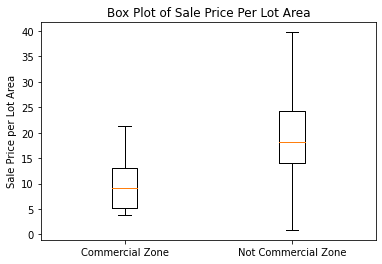

In [60]:
df2.groupby(df2['Commercial'])['Commercial'].count()
plt.boxplot([df2.loc[df2['Commercial'] == 1, "SP_LA"],
             df2.loc[df2['Commercial'] == 0, "SP_LA"]],
            showfliers=False
)
plt.title('Box Plot of Sale Price Per Lot Area')
plt.ylabel('Sale Price per Lot Area')
plt.xticks(ticks=[1, 2],
           labels=["Commercial Zone", "Not Commercial Zone"]
);

In [11]:
df.groupby(df['MS_Zoning'])[['MS_Zoning']].count()

,MS_Zoning
MS_Zoning,
A (agr),2
C (all),19
FV,101
I (all),1
RH,14
RL,1598
RM,316


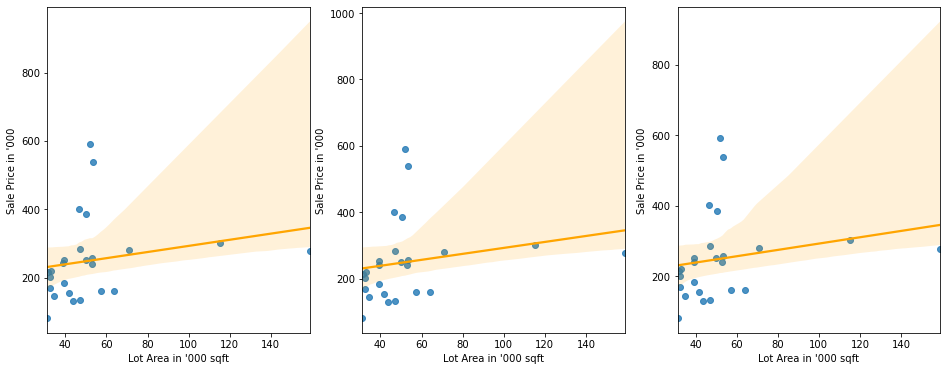

In [384]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
sns.regplot(data=df,
            x=df.loc[df['Lot_Area'] > 30000, 'Lot_Area']/1000,
            y=df.loc[df['Lot_Area'] > 30000, 'SalePrice']/1000,
            line_kws={'color': 'orange'}
)
plt.xlabel('Lot Area in \'000 sqft')
plt.ylabel('Sale Price in \'000');

plt.subplot(1, 3, 2)
sns.regplot(data=df,
            x=df.loc[df['Lot_Area'] > 30000, 'Lot_Area']/1000,
            y=df.loc[df['Lot_Area'] > 30000, 'SalePrice']/1000,
            line_kws={'color': 'orange'}
)
plt.xlabel('Lot Area in \'000 sqft')
plt.ylabel('Sale Price in \'000');

plt.subplot(1, 3, 3)
sns.regplot(data=df,
            x=df.loc[df['Lot_Area'] > 30000, 'Lot_Area']/1000,
            y=df.loc[df['Lot_Area'] > 30000, 'SalePrice']/1000,
            line_kws={'color': 'orange'}
)
plt.xlabel('Lot Area in \'000 sqft')
plt.ylabel('Sale Price in \'000');

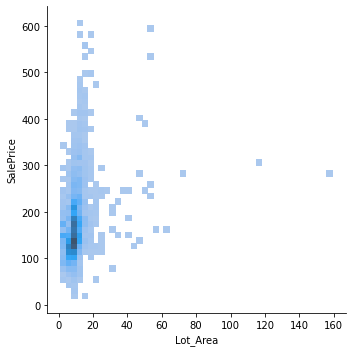

In [362]:
# sns.displot(data=df['Lot_Area']/1000,
#             kind='hist',
#             kde=True,
#             bins=50,
# );

sns.displot(data=df,
            x=df['Lot_Area']/1000,
            y=df['SalePrice']/1000,
#             kde=True,
            bins=50,
);

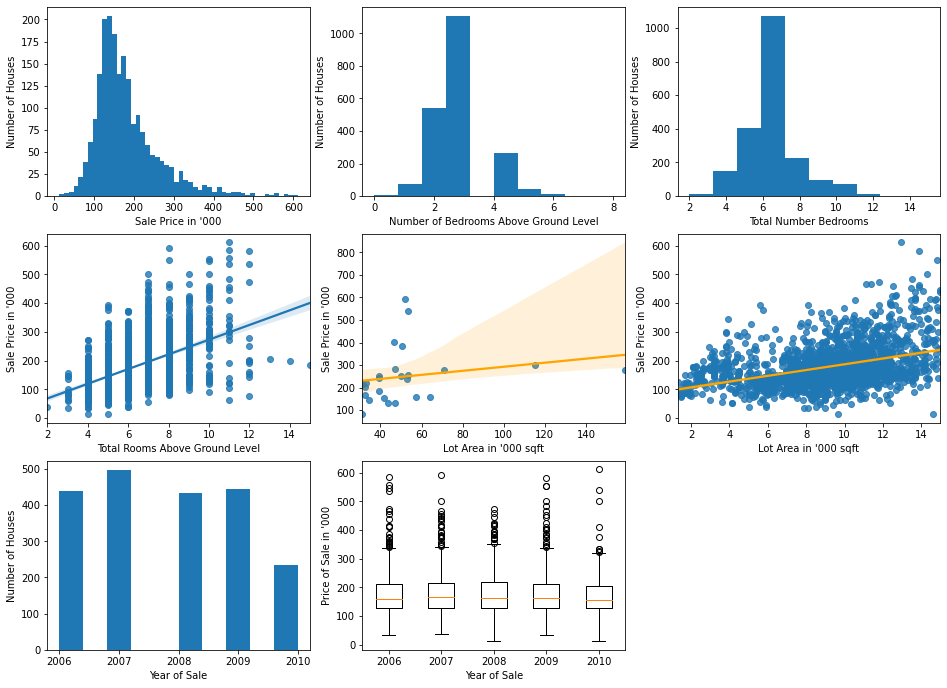

In [366]:
plt.figure(figsize=(16, 16))


plt.subplot(4, 3, 1)
plt.hist(df['SalePrice']/1000,
         bins=50
)
plt.xlabel('Sale Price in \'000')
plt.ylabel('Number of Houses')


plt.subplot(4, 3, 2)
plt.hist(df['Bedroom_AbvGr']
        );
plt.xlabel('Number of Bedrooms Above Ground Level')
plt.ylabel('Number of Houses')


plt.subplot(4, 3, 3)
plt.hist(df['TotRms_AbvGrd']
        );
plt.xlabel('Total Number Bedrooms')
plt.ylabel('Number of Houses')


plt.subplot(4, 3, 4)
sns.regplot(data=df,
            x='TotRms_AbvGrd',
            y=df['SalePrice']/1000,
            ci=95
)
plt.xlabel('Total Rooms Above Ground Level')
plt.ylabel('Sale Price in \'000');


plt.subplot(4, 3, 5)
sns.regplot(data=df,
            x=df.loc[df['Lot_Area'] > 30000, 'Lot_Area']/1000,
            y=df.loc[df['Lot_Area'] > 30000, 'SalePrice']/1000,
            line_kws={'color': 'orange'}
)
plt.xlabel('Lot Area in \'000 sqft')
plt.ylabel('Sale Price in \'000');


plt.subplot(4, 3, 6)
sns.regplot(data=df,
            x=df.loc[df['Lot_Area'] <= 15000, 'Lot_Area']/1000,
            y=df.loc[df['Lot_Area'] <= 15000, 'SalePrice']/1000,
            line_kws={'color': 'orange'}
)
plt.xlabel('Lot Area in \'000 sqft')
plt.ylabel('Sale Price in \'000');


plt.subplot(4, 3, 7)
plt.hist(df['Yr_Sold'],
);
plt.xlabel('Year of Sale')
plt.ylabel('Number of Houses')


plt.subplot(4, 3, 8)
plt.boxplot([df.loc[df['Yr_Sold'] == 2006,'SalePrice']/1000,
             df.loc[df['Yr_Sold'] == 2007,'SalePrice']/1000,
             df.loc[df['Yr_Sold'] == 2008,'SalePrice']/1000,
             df.loc[df['Yr_Sold'] == 2009,'SalePrice']/1000,
             df.loc[df['Yr_Sold'] == 2010,'SalePrice']/1000],
);
plt.xlabel('Year of Sale')
plt.ylabel('Price of Sale in \'000');
plt.xticks(ticks=[1, 2, 3, 4, 5],
           labels=['2006', '2007', '2008', '2009', '2010']
);

# plt.subplot(4, 3, 9)
# sns.regplot(data=df,
#             x=,
#             y=
# )

# plt.subplot(2, 3, 6)
# plt.boxplot(df['Lot_Area'],
#             showfliers=False
# );

In [241]:
Garage_Type_List = ['Attchd', 'Detchd', 'BuiltIn', 'Basment', '2Types', 'CarPort']

def garage_exist(row):
    for house in row:
        if row['Garage_Type'] in Garage_Type_List:
            row['Garage_Exist'] = 1
        else:
            row['Garage_Exist'] = 0
    return row

df = df.apply(garage_exist, axis=1)

In [243]:
df.head(2)
df.groupby('Garage_Exist')['Id'].count()
df.loc[df['Garage_Type'].isnull() == True, 'Id'].count()

113

In [5]:
df.head(2)

,Id,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000


In [ ]:
df.isna().sum()

In [15]:
df.dtypes

Id                int64
PID               int64
MS_SubClass       int64
MS_Zoning        object
Lot_Frontage    float64
                 ...   
Misc_Val          int64
Mo_Sold           int64
Yr_Sold           int64
Sale_Type        object
SalePrice         int64
Length: 81, dtype: object

In [ ]:
df.columns

In [ ]:
df.groupby('Sale Type')['Id'].count()